In [4]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as Data
import numpy as np
import matplotlib.pyplot as plt
import yaml

from data.sirst import IRSTD1kDataset, NUDTDataset

from utils.grad_expand_utils import *
from utils.utils import compute_weighted_mean_variance, keep_negative_by_top3_magnitude_levels, \
    add_uniform_points_v3

In [12]:
# cfg
cfg_path = './cfg.yaml'
with open(cfg_path) as f:
    cfg = yaml.safe_load(f)

# dataset
file_name = '_target'

trainset = NUDTDataset(base_dir=r"W:/DataSets/ISTD/NUDT-SIRST", mode="train", base_size=256, pt_label=True, \
                        pesudo_label=True, augment=False, turn_num=0, file_name=file_name, cfg=cfg)
img_path = "W:/DataSets/ISTD/NUDT-SIRST/trainval/images" 
# elif args.dataset == 'sirstaug':
#     trainset = SirstAugDataset(base_dir=r'./datasets/sirst_aug',
#                                mode='train', base_size=args.base_size)  # base_dir=r'E:\ztf\datasets\sirst_aug'
# trainset = IRSTD1kDataset(base_dir=r"W:/DataSets/ISTD/IRSTD-1k", mode="train", base_size=512, pt_label=True, \
#                             pesudo_label=True, augment=False, turn_num=0, file_name=file_name, cfg=cfg)
# img_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/images"
    
    
train_data_loader = Data.DataLoader(trainset, batch_size=32, shuffle=False, drop_last=False)

In [ ]:
def gradient_expand_one_size(region, scale_weight=[0.5, 0.5, 0.5], target_mask=None, alpha=0.5, beta=0.8, view=False):
    # 归一化区域像素，以形成更强烈的边缘
    region_ = (region - region.min())/(region.max() - region.min())
    # 梯度形成
    img_gradient_1 = img_gradient2(region_)  # 2*2 sober
    img_gradient_2 = img_gradient3(region_)  # 3*3 sober
    img_gradient_3 = img_gradient5(region_)  # 5*5 sobel
    
    # 梯度映射，突出中灰度的区分度
    img_gradient_1, img_gradient_2, img_gradient_3 = sigmoid_mapping3(img_gradient_1, 10), \
         sigmoid_mapping3(img_gradient_2, 10), sigmoid_mapping3(img_gradient_3, 10)
    # 多尺度融合
    img_gradient_ = grad_multi_scale_fusion(img_gradient_1, scale_weight[0]) * grad_multi_scale_fusion(img_gradient_2, scale_weight[0]) * \
        grad_multi_scale_fusion(img_gradient_3, scale_weight[0])
    # 使用target_mask来增强对应区域的梯度
    if target_mask is not None:
        img_gradient_ = alpha + (img_gradient_ - img_gradient_.min())/(img_gradient_.max() - img_gradient_.min() + 1e-11) * (1 - alpha)   # 变换
        target_mask = beta + (target_mask - target_mask.min())/(target_mask.max() - target_mask.min() + 1e-11) * (1 - beta)
        img_gradient_ = img_gradient_ * target_mask.unsqueeze(0).unsqueeze(0)   # (1,24,H,W) *(1,1,H,W)
    img_gradient_ = (img_gradient_ - img_gradient_.min())/(img_gradient_.max() - img_gradient_.min() + 1e-11)

    # 用单像素宽度的梯度替代模糊边缘的宽的梯度
    grad_mask = local_max_gradient(img_gradient_)
    img_gradient_4 = grad_mask * img_gradient_

    # 扩展梯度
    grad_boundary = boundary4gradient_expand(img_gradient_4, 1e3)
    expanded_grad = img_gradient_4
    region_size = region.shape[2] if region.shape[2] > region.shape[3] else region.shape[3]
    for z in range(region_size):
        expanded_grad_ = gradient_expand_one_step(expanded_grad)
        expanded_grad_ += grad_boundary
        expanded_grad_ = torch.where(expanded_grad > expanded_grad_, expanded_grad, expanded_grad_) * (expanded_grad_ > -1e-4)
        expanded_grad = expanded_grad_

    # for show
    target_angle_idx = 1
    expand0 = expanded_grad[:,target_angle_idx].clone()
    grad_0 = (img_gradient_4[:,target_angle_idx].clone() > 0.1).float()
    grad_12 = (grad_boundary[:,target_angle_idx].clone() * -1e-3 > 0.1).float()
    expand0 = torch.clamp_min(expand0, 0)
    pict_rgb = torch.cat([expand0+grad_12, expand0,expand0+grad_0])
    plt.figure(figsize=(5, 5))
    plt.imshow(pict_rgb.permute(1,2,0))
    plt.show()

    # plt.figure(figsize=(5, 5))
    # plt.imshow(expanded_grad[0, 2], cmap='gray')
    # plt.show()

    _target = torch.sum(expanded_grad[0], dim=0)
    _target = (_target - _target.min())/(_target.max() - _target.min())

    # # 显示结果
    # angle_idx = 3
    # grad_boundary_4show = torch.cat((-grad_boundary[:,angle_idx]*1e-20, torch.zeros_like(grad_boundary[:,angle_idx]), torch.zeros_like(grad_boundary[:,angle_idx])), dim=0)
    # plt.figure(figsize=(25, 5))
    # plt.subplot(151), plt.imshow(region[:,0].repeat(3,1,1).permute(1,2,0))
    # plt.subplot(152), plt.imshow((img_gradient_4[:,angle_idx].repeat(3,1,1) + grad_boundary_4show).permute(1,2,0))
    # plt.subplot(153), plt.imshow(grad_boundary_4show.permute(1,2,0))
    # plt.subplot(154), plt.imshow(expanded_grad[:,angle_idx].repeat(3,1,1).permute(1,2,0))
    # plt.subplot(155), plt.imshow(_target.unsqueeze(0).repeat(3,1,1).permute(1,2,0))
    # plt.show()
    if view:
        return _target, (img_gradient_1, img_gradient_2, img_gradient_3, img_gradient_4, grad_mask, grad_boundary, expanded_grad)
    return _target, ()

In [14]:
def initial_target(grad_intensity: torch.Tensor, pt_label: torch.Tensor, threshold: float = 0.1):
        """
        Args:
            grad_intensity: 输入图像 [H, W]
            threshold: 阈值，用于初步划分种子点是否为有效种子点，如前景种子点需>threshold，背景种子点需<threshold
        Returns:
            seed_cofidence: 概率图 [H, W, 2]
        """
        H, W = grad_intensity.shape

        # 找局部最高值，再梯度强度➗局部最大值，进行局部归一化
        local_max = F.max_pool2d(grad_intensity.unsqueeze(0).unsqueeze(0), (5,5), stride=1, padding=2)
        local_norm_GI = grad_intensity / (local_max + 1e-11)

        # 局部最大值
        local_max2 = F.max_pool2d(local_norm_GI, (3,3), stride=1, padding=1)
        summit_mask = (local_norm_GI == local_max2)
        local_norm_GI = local_norm_GI.squeeze(0).squeeze(0)
        summit_mask = summit_mask.squeeze(0).squeeze(0)

        fg_area = (grad_intensity > threshold).float()
        bg_area = 1 - fg_area

        noise_ratio = 0.05
        converge_time = 0
        for iter1 in range(50):
            fg_mask = (summit_mask * (fg_area > 0.1)).float()
            bg_mask = (summit_mask * (bg_area > 0.1)).float()
            for iter2 in range(100):
                noise = torch.rand(grad_intensity.shape)
                GI = grad_intensity * (1-noise_ratio) + noise * noise_ratio
                fig = plt.figure(figsize=(20, 5))
                # plt.subplot(1, 7, 1)
                # plt.imshow(GI.view(H, W), cmap='gray', vmax=1.0, vmin=0.0)
                # plt.subplot(1, 7, 2)
                # plt.imshow(fg_mask.view(H, W), cmap='gray', vmax=1.0, vmin=0.0)
                # plt.subplot(1, 7, 3)
                # plt.imshow(bg_mask.view(H, W), cmap='gray', vmax=1.0, vmin=0.0)

                max_num = np.ceil(fg_mask.sum().item())
                min_num = np.ceil(bg_mask.sum().item())

                if max_num > 3 and min_num > 5:
                    fg_ratio = 1 - max_num /(fg_area.sum() + 1e-8)
                    bg_ratio = 1 - min_num /(bg_area.sum() + 1e-8)
                    fg_ratio = max(fg_ratio, 0.20)
                    bg_ratio = max(bg_ratio, 0.20)

                    local_max_num = 4 if max_num * fg_ratio < 4 else max_num * fg_ratio
                    _, fg_vwo, _, fg_v = compute_weighted_mean_variance(GI, fg_mask > 0.1, int(local_max_num))

                    local_min_num = 6 if min_num * bg_ratio < 6 else min_num * bg_ratio
                    _, bg_vwo, _, bg_v = compute_weighted_mean_variance(GI, bg_mask > 0.1, int(local_min_num))
                    # print(local_max_num, local_min_num)
                    result_ = fg_v/(fg_vwo+1e-8) - bg_v/(bg_vwo+1e-8)   #(H,W)
                    # result_ = keep_negative_by_top2_magnitude_levels(result_)

                    # print(GI)
                    # print("result_")
                    # print(result_)
                    # print(fg_vwo)
                    # print(bg_vwo)
                    # print((fg_v/(fg_vwo+1e-8) - 1))
                    # print((bg_v/(bg_vwo+1e-8) - 1))

                    # plt.subplot(1, 7, 4)
                    # plt.imshow((bg_v/(bg_vwo+1e-8)-1), cmap='gray')
                    # plt.subplot(1, 7, 5)
                    # plt.imshow((fg_v/(fg_vwo+1e-8)-1), cmap='gray')
                    # plt.title(f'max{bg_vwo.max():3e}, min{bg_vwo.min():3e}')

                    # plt.subplot(1, 4, 1)
                    # plt.imshow(bg_vwo, cmap='gray', vmax=0.24, vmin=0.),  plt.axis('off')
                    # plt.subplot(1, 4, 2)
                    # plt.imshow(fg_vwo, cmap='gray', vmax=0.24, vmin=0.),  plt.axis('off')

                    # plt.subplot(1, 4, 3)
                    # plt.imshow(bg_v, cmap='gray', vmax=0.24, vmin=0.),  plt.axis('off')
                    # plt.subplot(1, 4, 4)
                    # plt.imshow(fg_v, cmap='gray', vmax=0.24, vmin=0.),  plt.axis('off')
                    # plt.show()
                    # a = input()
                else:
                    result_ = torch.where(fg_area > 0.1, -GI, GI)
                result_ = keep_negative_by_top3_magnitude_levels(result_, target_size=fg_area.sum())
                result = torch.where(result_ < 0., torch.ones_like(GI), torch.zeros_like(GI)).bool()
                # result = filter_mask_by_points(result, pt_label, kernel_size=5).bool()


                fg_seed_num = int(0.1*max_num)
                fg_seed_num = fg_seed_num if fg_seed_num > 2 else 2
                # if fitted != 1:
                fg_mask_new = add_uniform_points_v3(GI, (fg_area > 0.1) * (result_ < 0.), fg_mask>0.1, int(fg_seed_num), mode='fg')
                # else:
                # fg_mask_new = add_uniform_points_cuda((fg_area > 0.1) * (result_ < 0.), fg_mask>0.1, int(fg_seed_num))
                fg_mask_new = fg_mask_new.bool() * result

                bg_seed_num = int(0.1*min_num)
                bg_seed_num = bg_seed_num if bg_seed_num > 8 else 8
                # if fitted != 1:
                # bg_mask_new = add_uniform_points_cuda((bg_area > 0.1) * (result_ >= 0.), bg_mask>0.1, int(bg_seed_num))
                bg_mask_new = add_uniform_points_v3(GI, (bg_area > 0.1) * (result_ >= 0.), bg_mask>0.1, int(bg_seed_num), mode='bg')
                # else:
                # bg_mask_new = add_uniform_points_cuda((bg_area > 0.1) * (result_ > 0.), bg_mask>0.1, int(bg_seed_num))
                bg_mask_new = bg_mask_new.bool() * ~result

                diff = torch.norm(fg_mask_new.float() - (fg_mask > 0.1).float()) 
                if diff < 1:
                    # print(f"iter1 {iter1} iter2 Converged at {iter2}")
                    break
                # else:
                #     print(f"iter1 {iter1} iter2 {iter2}, Diff: {diff}")

                plt.subplot(1, 4, 3)
                plt.imshow(fg_mask_new, cmap='gray'),  plt.axis('off')
                plt.subplot(1, 4, 4)
                plt.imshow(result, cmap='gray'),  plt.axis('off')
                plt.subplot(1, 4, 2)
                plt.imshow(bg_mask_new, cmap='gray'),  plt.axis('off')
                plt.show()
                a = input()

                decay_rate = 0.8
                fg_mask, bg_mask = fg_mask_new.float() + fg_mask*decay_rate, bg_mask_new.float() + bg_mask*decay_rate
                fg_mask, bg_mask = torch.clamp(fg_mask, min=0.0, max=1.0), torch.clamp(bg_mask, min=0.0, max=1.0)
            
            # fig = plt.figure(figsize=(15, 5))
            # plt.subplot(1, 3, 1)
            # plt.imshow(GI.view(H, W), cmap='gray', vmax=1.0, vmin=0.0)
            # plt.subplot(1, 3, 2)
            # plt.imshow(result, cmap='gray', vmax=1.0, vmin=0.0)
            # plt.subplot(1, 3, 3)
            # plt.imshow(fg_area, cmap='gray', vmax=1.0, vmin=0.0)
            # plt.show(block=False)
            # a = input()
            # 修改area
            # result = filter_mask_by_points(result, pt_label, kernel_size=5).bool()
            # print(f"iter2 Converged at{iter2}, Diff: {diff}")
            fg_area_new = result
            bg_area_new = ~result
            diff = torch.norm(bg_area_new.float() - bg_area.float())
            if diff < (H * W / 64) ** 0.5:
                converge_time += 1
                # print(f"iter1 Converged at{iter1}, Diff: {diff}")
            if converge_time > 3:
                break
            # else:
            #     print(f"iter1 {iter1}, Diff: {diff}")
            if result.float().sum() < 4:
                noise_ratio = noise_ratio * 0.5
                continue
            noise_ratio = noise_ratio * 0.9
            if fg_area_new.sum() > (grad_intensity > 0.1).float().sum() * 2 and (H + W) > 96:
                break
            decay_rate = 0.5
            fg_area, bg_area = fg_area_new.float() + fg_area*decay_rate, bg_area_new.float()+ bg_area*decay_rate
            fg_area, bg_area = torch.clamp(fg_area, min=0.0, max=1.0), torch.clamp(bg_area, min=0.0, max=1.0)

        return result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.996355].


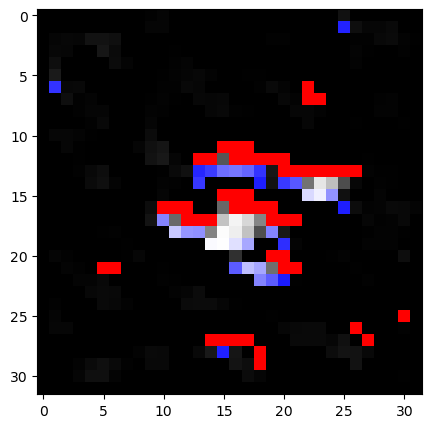

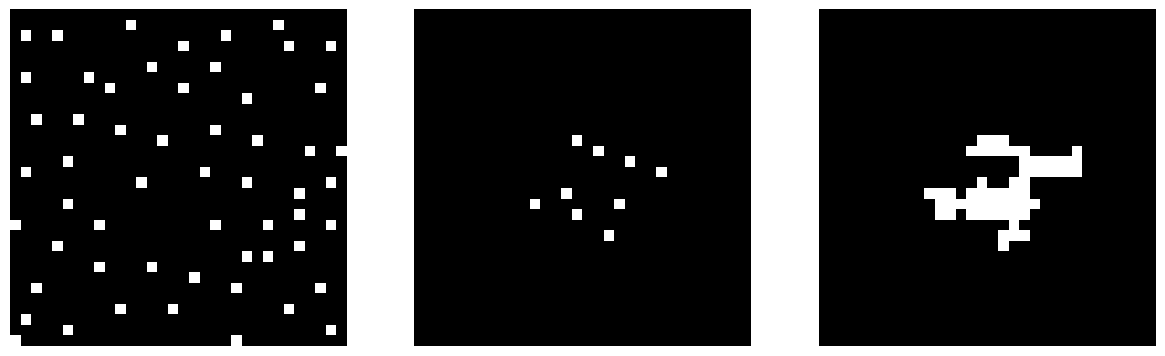

KeyboardInterrupt: Interrupted by user

In [15]:
for j, (img, pt_label, pesudo_label) in enumerate(train_data_loader):
    B, _, H, W = img.shape
    indices = torch.where(pt_label > 1e-4)

    for b, _, s1, s2 in zip(*indices):
        # 提取区域
        targets = []
        size = 32

        y1 = max(1, s1 - size // 2)
        x1 = max(1, s2 - size // 2)
        y2 = min(H-1, s1 + (size - size // 2))
        x2 = min(W-1, s2 + (size - size // 2))
        _region = img[b:b+1,:1, y1:y2, x1:x2]

        _target, _ = gradient_expand_one_size(_region, [0.5, 0.5, 0.5])

        p_label = initial_target(_target, pt_label[b, 0, s1, s2], threshold=0.1)


In [3]:
a = 0.27//0.1
print(a)

2.0
